# P4 Work with the databases
### Team 6: Geyiwen Ma, Kehui Wang, Yucheng Qiu, Zhonghao Gu

In the P4, we mainly shows some potential functions that can be implemented from our database, including basic listing, search, and analytics by wordcloud. To go more further, we can implement deeper NLP analysis on the customer reviews texts.

##### *Important notes: 

We have already fed the data to Cassandra through our ETL Pipeline (please reference P3). In this part, we will still use cassandra-driver with Python to retrieve data **remotely** from the database (which is located in Datastax). In each section (1~4), we execute CQL query and retrieving data first, and then show the function implemented or work on analytics by Python. 

In [55]:
import pandas as pd
import cassandra
import re
import os
import glob
import numpy as np
import json
from prettytable import PrettyTable
import datetime
from matplotlib import pyplot as plt
# from local-written python function
from my_wordcloud import word_cloud_generate

# 0 CONNECT TO THE DATABASE

In [3]:
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider

cloud_config= {
        'secure_connect_bundle': 'C:/Users/qycer/iCloudDrive/INFO7275/Project/secure-connect-team6-projecct.zip'
}
auth_provider = PlainTextAuthProvider('team6', 'info7275')
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
session = cluster.connect()

row = session.execute("select release_version from system.local").one()
if row:
    print(row[0])
else:
    print("An error occurred.")

4.0.0.684


In [4]:
############# SET THE KEYSPACES ########
try:
    session.set_keyspace('project')
except Exception as e:
    print(e)

# 1 Get the Product List

In [204]:
select_product_info = """SELECT productid, productname, brand, colors, primaryCategories
                        FROM product
                        """

try:
    rows = session.execute(select_product_info)
    tbl1 = []
    for row in rows:
        tbl1.append([row.productid, row.productname, row.brand, row.colors, row.primarycategories])
except Exception as e:
    print(e)
product_info = pd.DataFrame(tbl1, columns=['Product_ID', 'ProductName', 'Brand', 'Colors', 'Category'])

In [207]:
product_info.head()

,Product_ID,ProductName,Brand,Colors,Category
0,AVpiAzN7ilAPnD_x_wOJ,Bowers & Wilkins P7 Wired Over Ear Headphones,Bowers & Wilkins,"Black,White",Electronics
1,AVphRsH11cnluZ0-Agzr,"JBL - 6"" x 8"" 2-Way Coaxial Car Speakers with ...",JBL,"Multicolor,Black,Grey",Electronics
2,AVpi-P111cnluZ0-SVqq,Clarity - Super-Loud Phone Ringer - White,CLARITY-TELECOM,Cream,Electronics
3,AVpgjaudilAPnD_xuDKC,Travel RockStar 3-in-1 2A USB and Dual-Outlet ...,Belkin,"Black,White",Electronics
4,AVpe8ZRY1cnluZ0-aY4H,Round LCD/Projector Ceiling Plate - Black,Peerless-AV,Black,Electronics


# 2  Search products by the brand

In [ ]:
select_product_bybrand = """SELECT productid, productname, brand, colors, primaryCategories
                        FROM product
                        WHERE brand = 'Sony'
                        """

try:
    rows = session.execute(select_product_bybrand)
    tbl2 = []
    for row in rows:
        tbl2.append([row.productid, row.productname, row.brand, row.colors, row.primarycategories])
except Exception as e:
    print(e)
product_bybrand = pd.DataFrame(tbl2, columns=['Product_ID', 'ProductName', 'Brand', 'Colors', 'Category'])

In [238]:
product_bybrand

,Product_ID,ProductName,Brand,Colors,Category
0,AVpfKRGKLJeJML433rPX,Sony SRSHG1/BLK Hi-Res Wireless Speaker- Charc...,Sony,"Red,Pink,Yellow,Blue,Bordeaux Pink,Cinnabar Re...",Electronics
1,AVpfgGwSLJeJML43-VCn,SRS-ZR7 Wireless Speaker,Sony,Black,Electronics
2,AVpfjP9uilAPnD_xdy6-,Sony Mini Digital Video Cassettes - DVC - 1 Hour,Sony,Multicolor,Electronics
3,AVpfuJ4pilAPnD_xhDyM,Sony LBT-GPX555 Mini-System with Bluetooth and...,Sony,Black,Electronics
4,AVpjedgc1cnluZ0-W4NI,Sony MEXM100BT 160W RMS Marine CD Receiver wit...,Sony,Multicolor,Electronics
5,AVsRhL-fQMlgsOJE6zvB,Sony SRSXB30/BLK XB30 Portable Wireless Speake...,Sony,"Black,Gray,Red,Blue",Electronics


# 3  Word Cloud Visualization of Customer Reviews Data

Fill in the parameters to filter the review:

In [212]:
query_params = {
    'productid': 'AVpgGPyq1cnluZ0-wbTJ',
    'brand': "Sony",
    'reviews_date_from': '2013-01-01',
    'reviews_date_to': '2017-01-01'
}

Generate queries: (In this sample, we can filter by brand / ProductID / ProductID & reviews_date)

In [244]:
#BY Brand Condition Sentence
try:
    query_params['brand']
except KeyError:
    var_exists = False
    brand_cond = ''
else:
    var_exists = True
    brand_cond = ("brand = '" + query_params['brand'] + "' ") if query_params['brand'] else ''



#BY PRODUCT_ID Condition Sentence
prodid_cond = ("productid = '" + query_params['productid'] + "' ") if query_params['productid'] else ''

#BY Reviews_date Condition Sentence
date_from = query_params['reviews_date_from'] if query_params['reviews_date_from'] else '2007-09-01'
date_to = query_params['reviews_date_to'] if query_params['reviews_date_from'] else '2020-12-01'

date_cond = (" AND reviews_date >= '" + query_params['reviews_date_from'] + "' AND reviews_date <= '" +
             query_params['reviews_date_to'] + "'")



review_by_brand = ("SELECT * FROM customer_reviews " +
                    "WHERE " + brand_cond +
                    " ALLOW FILTERING")

review_by_product = ("SELECT productid, productname, brand, reviews_text, reviews_date FROM customer_reviews " +
                   "WHERE " + prodid_cond +
                   " ALLOW FILTERING")
review_by_date_and_prod = ("SELECT productid, productname, brand, reviews_text, reviews_date FROM customer_reviews " +
                   "WHERE " + prodid_cond + date_cond +
                   " ALLOW FILTERING")

#### The dynamic CQL sentence display:

In [228]:
##Query to be executed:
reviews_query = review_by_date_and_prod
print(reviews_query)

SELECT productid, productname, brand, reviews_text, reviews_date FROM customer_reviews WHERE productid = 'AVpgGPyq1cnluZ0-wbTJ'  AND reviews_date >= '2013-01-01' AND reviews_date <= '2017-01-01' ALLOW FILTERING


In [229]:
try:
    rows = session.execute(reviews_query)
    reviews_to_feed_wordcloud = []
    t = PrettyTable(['Product_id', 'ProductName','Brand'])
    for row in rows:
        reviews_to_feed_wordcloud.append(row.reviews_text)
    t.add_row([row.productid, row.productname, row.brand])
except Exception as e:
    print(e)
print(t)

+----------------------+---------------------------------+----------+
|      Product_id      |           ProductName           |  Brand   |
+----------------------+---------------------------------+----------+
| AVpgGPyq1cnluZ0-wbTJ | Motorola Wi-Fi Pet Video Camera | Motorola |
+----------------------+---------------------------------+----------+


#### The word cloud of all the reviews text to the product showed above:

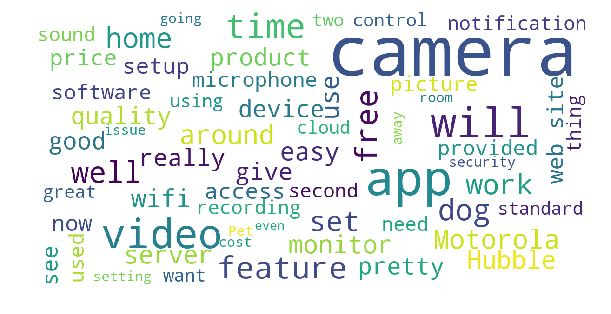

In [240]:
word_cloud_generate(reviews_to_feed_wordcloud, get_adj = False)

#### The word cloud of all the reviews text to the product (Show adjective words only):

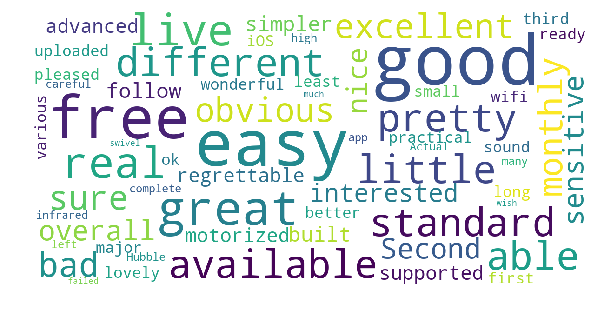

In [241]:
word_cloud_generate(reviews_to_feed_wordcloud, get_adj = True)

# 4 Product Review Scores

As a common function in every online store, we are going to display the summary plot of customer reviews.

First, let's set the product id that we are interested in:

In [ ]:
target_product_id = 'AVpfgGwSLJeJML43-VCn'

The following dynamic query will print the query sentence to get the ratings data.

In [19]:
prodid_condition = ("productid = '" + target_product_id + "' ")


query_rating_list = ("SELECT reviews_rating FROM customer_reviews " +
                   "WHERE " + prodid_condition +
                   " ALLOW FILTERING;")

query_avg_score = ("SELECT productid, productname, brand, avg(reviews_rating) as avg_score" + 
                   " FROM customer_reviews WHERE " + 
                     prodid_condition + " ALLOW FILTERING;")

             
print(query_avg_score)

SELECT productid, productname, brand, avg(reviews_rating) as avg_score FROM customer_reviews WHERE productid = 'AVpfgGwSLJeJML43-VCn'  ALLOW FILTERING;


In [35]:
try:
    
    info = session.execute(query_avg_score) 
    t = PrettyTable(['Product_id', 'ProductName','Brand', 'Average Ratings'])
    for info_row in info:
        t.add_row([info_row.productid, info_row.productname, info_row.brand, round(info_row.avg_score,3)])
    
    rows = session.execute(query_rating_list)
    rating_list = []
    for row in rows:
        rating_list.append(row.reviews_rating)
    
except Exception as e:
    print(e)
print(t)

+----------------------+--------------------------+-------+-----------------+
|      Product_id      |       ProductName        | Brand | Average Ratings |
+----------------------+--------------------------+-------+-----------------+
| AVpfgGwSLJeJML43-VCn | SRS-ZR7 Wireless Speaker |  Sony |      4.302      |
+----------------------+--------------------------+-------+-----------------+


In [53]:
rating_summ = { 'five_stars': sum(1 for i in rating_list if i == 5),
'four_stars': sum(1 for i in rating_list if i == 4),
'three_stars': sum(1 for i in rating_list if i == 3),
'two_stars': sum(1 for i in rating_list if i == 2),
'one_star': sum(1 for i in rating_list if i == 1)
    }


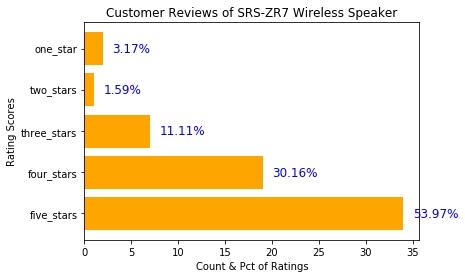

In [134]:
x_coord = list(rating_summ.values())
y_coord = list(rating_summ.keys())
pct_text = [ str(round(i*100/sum(x_coord),2))+"%" for i in x_coord]
plt.barh(y_coord, x_coord, color = 'orange')
plt.xlabel("Count & Pct of Ratings")
plt.ylabel("Rating Scores")
plt.title("Customer Reviews of " + info_row.productname)

for v, i in enumerate(x_coord):
    plt.text(i+1, v, pct_text[v], va = 'center', color = 'blue', size = 'large')

# Appendix: my_wordcloud function

    from textblob import TextBlob
    import nltk
    import pandas as pd
    from wordcloud import WordCloud,STOPWORDS
    import matplotlib.pyplot as plt


    def word_cloud_generate(column_of_df, get_adj = True): 
    
    string = column_of_df if isinstance(column_of_df, str) else str(column_of_df)
    
    def get_adjectives(text):
        blob = TextBlob(text)
        return [ word for (word,tag) in blob.tags if tag.startswith("JJ")] 
    

    string_to_cloud = string
    if get_adj:
        string_adj = get_adjectives(string)
        string_to_cloud = str(string_adj).replace("'","").replace(",", " ").replace("[", "").replace("]", "")

    stopwords=set(STOPWORDS)
    def Mywordcloud(data, title=None):
        wordcloud=WordCloud(
            background_color='white',
            stopwords=stopwords,
            max_words=60,
            max_font_size=50,
            scale=3,
            random_state=1
        ).generate(data)
        fig=plt.figure(1,figsize=(10,10))
        plt.axis('off')
        if title:
            fig.suptitle(title,fontsize=20)
            fig.subplots_adjust(top=2.3)
        plt.imshow(wordcloud)
        plt.show()
    Mywordcloud(string_to_cloud)